In [1]:
# Import necessary modules
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.ga.ga_member import Member
from core.ga.ga_params import GeneticAlgorithmParams

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances

from core.model.model_helpers import plot_crop_growth_results, plot_nutrient_factor_evolution, plot_growth_rate_evolution, plot_carrying_capacity_evolution

## Model Parameters

In [2]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt = 0.1, # hours/step
    simulation_hours = 2900 # hours
)

In [3]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [4]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [5]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

## Cost function weights

In [6]:
ga_params = GeneticAlgorithmParams()
weight_fruit_biomass = ga_params.weight_fruit_biomass
weight_irrigation = ga_params.weight_irrigation
weight_fertilizer = ga_params.weight_fertilizer

## Input Disturbances

In [7]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../../io/inputs/hourly_prcp_rad_temp_iowa.csv'
)

In [8]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = hourly_input_disturbances['Hourly Precipitation (in)'].to_numpy(),
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Control Inputs

In [9]:
with open('ga_parallel_results/ga_parallel_best_inputs_dict.json', 'r') as f:
    best_inputs_dict = json.load(f)

In [10]:
control_input_key = '1'

In [11]:
irrigation_frequency = best_inputs_dict[control_input_key]['irrigation_frequency']
irrigation_amount    = best_inputs_dict[control_input_key]['irrigation_amount']
fertilizer_frequency = best_inputs_dict[control_input_key]['fertilizer_frequency']
fertilizer_amount    = best_inputs_dict[control_input_key]['fertilizer_amount']
'''
# Carla test params
irrigation_frequency = 24 * 7 * 2 # Irrigate once every 336 hours
irrigation_amount    = 0.1        # with 0.1 inches per irrigation (goal is 28 in including precip)
fertilizer_frequency = 24 * 30 * 3 # Fertilize once every 720 hours
fertilizer_amount    = 100        # with 100 lbs per fertilization (goal is 355 lbs over season)

# Test params
irrigation_frequency = 2.55302863e+02
irrigation_amount    = 5.23706758e-03 
fertilizer_frequency = 1.22278983e+03
fertilizer_amount    = 4.57621593e-02
'''

'\n# Carla test params\nirrigation_frequency = 24 * 7 * 2 # Irrigate once every 336 hours\nirrigation_amount    = 0.1        # with 0.1 inches per irrigation (goal is 28 in including precip)\nfertilizer_frequency = 24 * 30 * 3 # Fertilize once every 720 hours\nfertilizer_amount    = 100        # with 100 lbs per fertilization (goal is 355 lbs over season)\n\n# Test params\nirrigation_frequency = 2.55302863e+02\nirrigation_amount    = 5.23706758e-03 \nfertilizer_frequency = 1.22278983e+03\nfertilizer_amount    = 4.57621593e-02\n'

In [12]:
# Apply irrigation and fertilizer based on the defined frequency and amount
simulation_hours = len(input_disturbances.precipitation)
hourly_irrigation = np.zeros(simulation_hours)
for t in range(0, simulation_hours, np.floor(irrigation_frequency).astype(int)):
    hourly_irrigation[t] = irrigation_amount

hourly_fertilizer = np.zeros(simulation_hours)
for t in range(0, simulation_hours, np.floor(fertilizer_frequency).astype(int)):
    hourly_fertilizer[t] = fertilizer_amount

## Optimal/Typical Values

In [13]:
typical_disturbances = ModelTypicalDisturbances()

## GA Params (just to use Member class)

In [14]:
# Genetic algorithm style inputs
ga_params = GeneticAlgorithmParams()

## Simulation of Plant Growth over Season for Different Sensitivities

In [15]:
# Construct an instance of the Member class
member = Member(
    ga_params            = ga_params,
    carrying_capacities  = carrying_capacities,
    disturbances         = input_disturbances,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    model_params         = model_params,
    typical_disturbances = typical_disturbances,
    values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
)

In [16]:
# Define sweeps for sensitivity analysis
nuW_sensitivities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nuF_sensitivities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nuT_sensitivities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nuR_sensitivities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Set default sensitivity values
nuW_sens_default = 0.9
nuF_sens_default = 0.9
nuT_sens_default = 0.9
nuR_sens_default = 0.9

## Simulate over different WATER sensitivities

In [17]:
# Loop over sensitivity values for nuW using default values for others
hs = []
As = []
Ns = []
cs = []
Ps = []
labels = []

nuWs = []
nuFs = []
nuTs = []
nuRs = []

ah_hats = []
aA_hats = []
aN_hats = []
ac_hats = []
aP_hats = []

kh_hats = []
kA_hats = []
kN_hats = []
kc_hats = []
kP_hats = []

for nuW_sens in nuW_sensitivities:
    print(f"Running simulation with nuW sensitivity: {nuW_sens}")
    h, A, N, c, P, nuW_values, nuF_values, nuT_values, nuR_values, ah_hat_values, aA_hat_values, aN_hat_values, ac_hat_values, aP_hat_values, kh_hat_values, kA_hat_values, kN_hat_values, kc_hat_values, kP_hat_values = member.get_closed_form_cost_verbose(nuW_sens=nuW_sens, nuF_sens=nuF_sens_default, nuT_sens=nuT_sens_default, nuR_sens=nuR_sens_default)
    hs.append(h)
    As.append(A)
    Ns.append(N)
    cs.append(c)
    Ps.append(P)
    labels.append(f'nuW_sens={nuW_sens}')

    nuWs.append(nuW_values)
    nuFs.append(nuF_values)
    nuTs.append(nuT_values)
    nuRs.append(nuR_values)

    ah_hats.append(ah_hat_values)
    aA_hats.append(aA_hat_values)
    aN_hats.append(aN_hat_values)
    ac_hats.append(ac_hat_values)
    aP_hats.append(aP_hat_values)

    kh_hats.append(kh_hat_values)
    kA_hats.append(kA_hat_values)
    kN_hats.append(kN_hat_values)
    kc_hats.append(kc_hat_values)
    kP_hats.append(kP_hat_values)

Running simulation with nuW sensitivity: 0.1
Running simulation with nuW sensitivity: 0.2
Running simulation with nuW sensitivity: 0.3
Running simulation with nuW sensitivity: 0.4
Running simulation with nuW sensitivity: 0.5
Running simulation with nuW sensitivity: 0.6
Running simulation with nuW sensitivity: 0.7
Running simulation with nuW sensitivity: 0.8
Running simulation with nuW sensitivity: 0.9


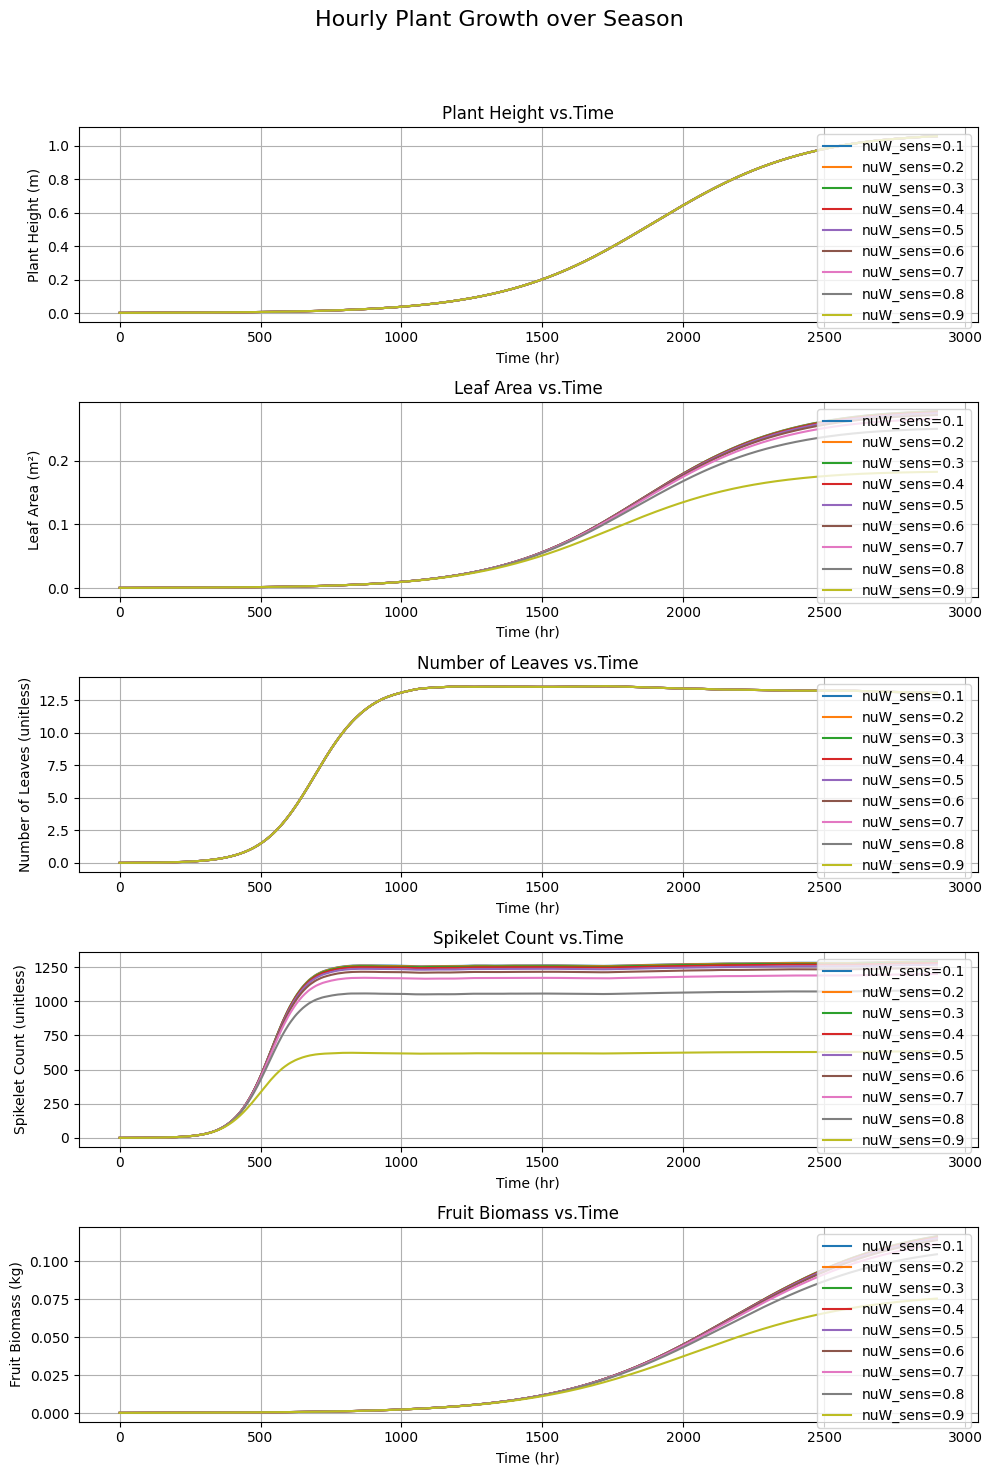

In [18]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass over time
plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    dt=model_params.dt,
    labels=labels
)

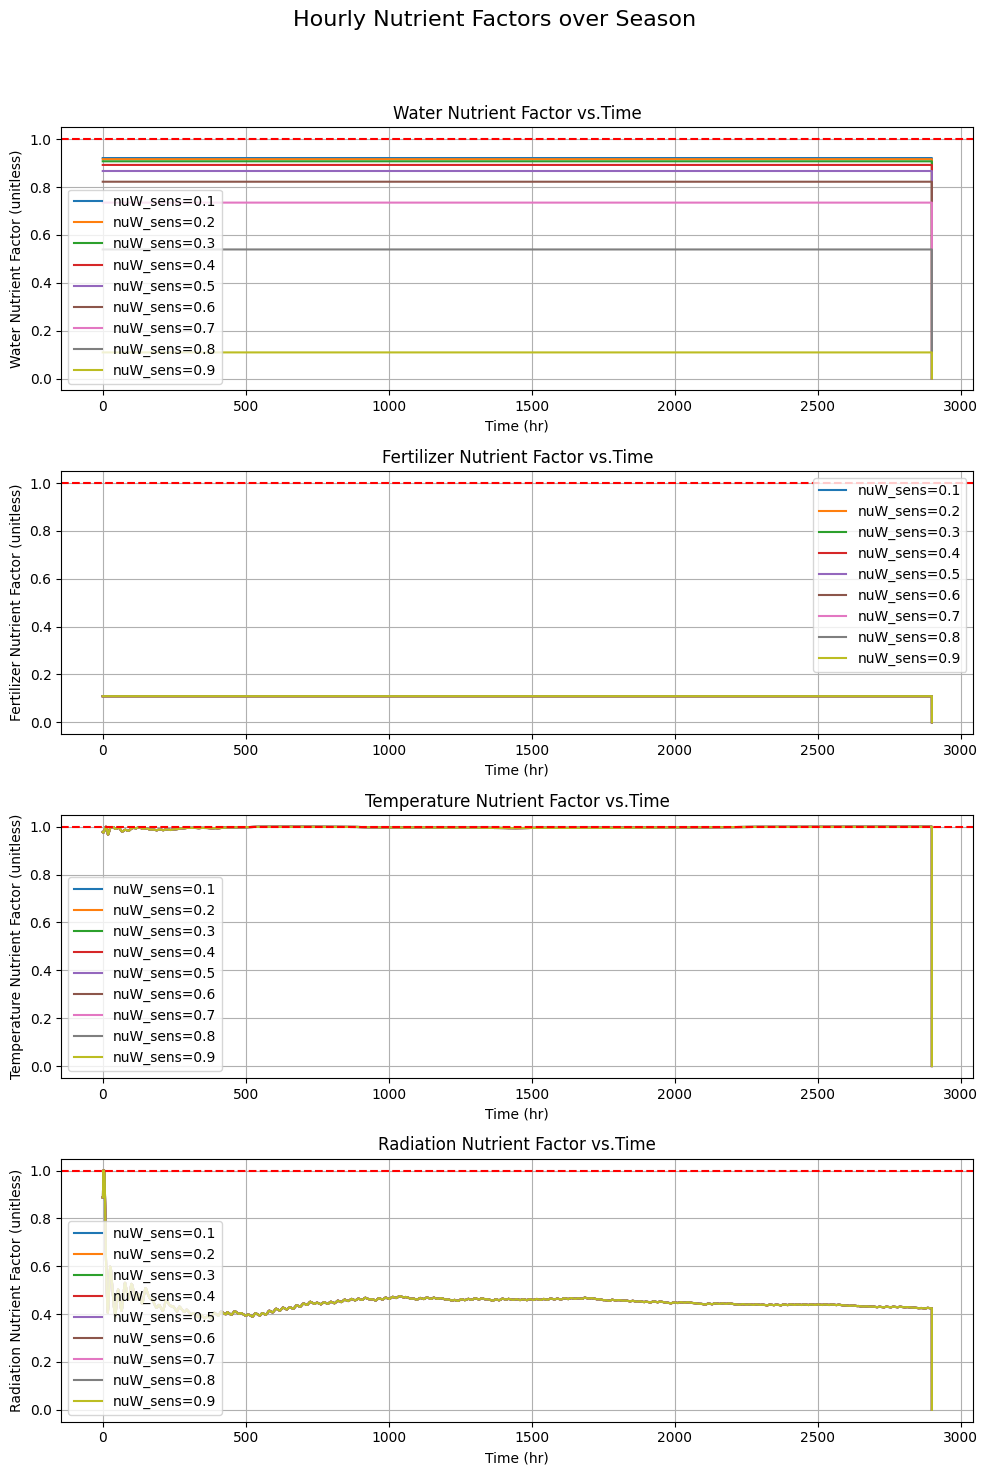

In [19]:
# Plot nuW, nuF, nuT, and nuF over time
plot_nutrient_factor_evolution(
    nuWs=nuWs,
    nuFs=nuFs,
    nuTs=nuTs,
    nuRs=nuRs,
    dt=model_params.dt,
    labels=labels
)

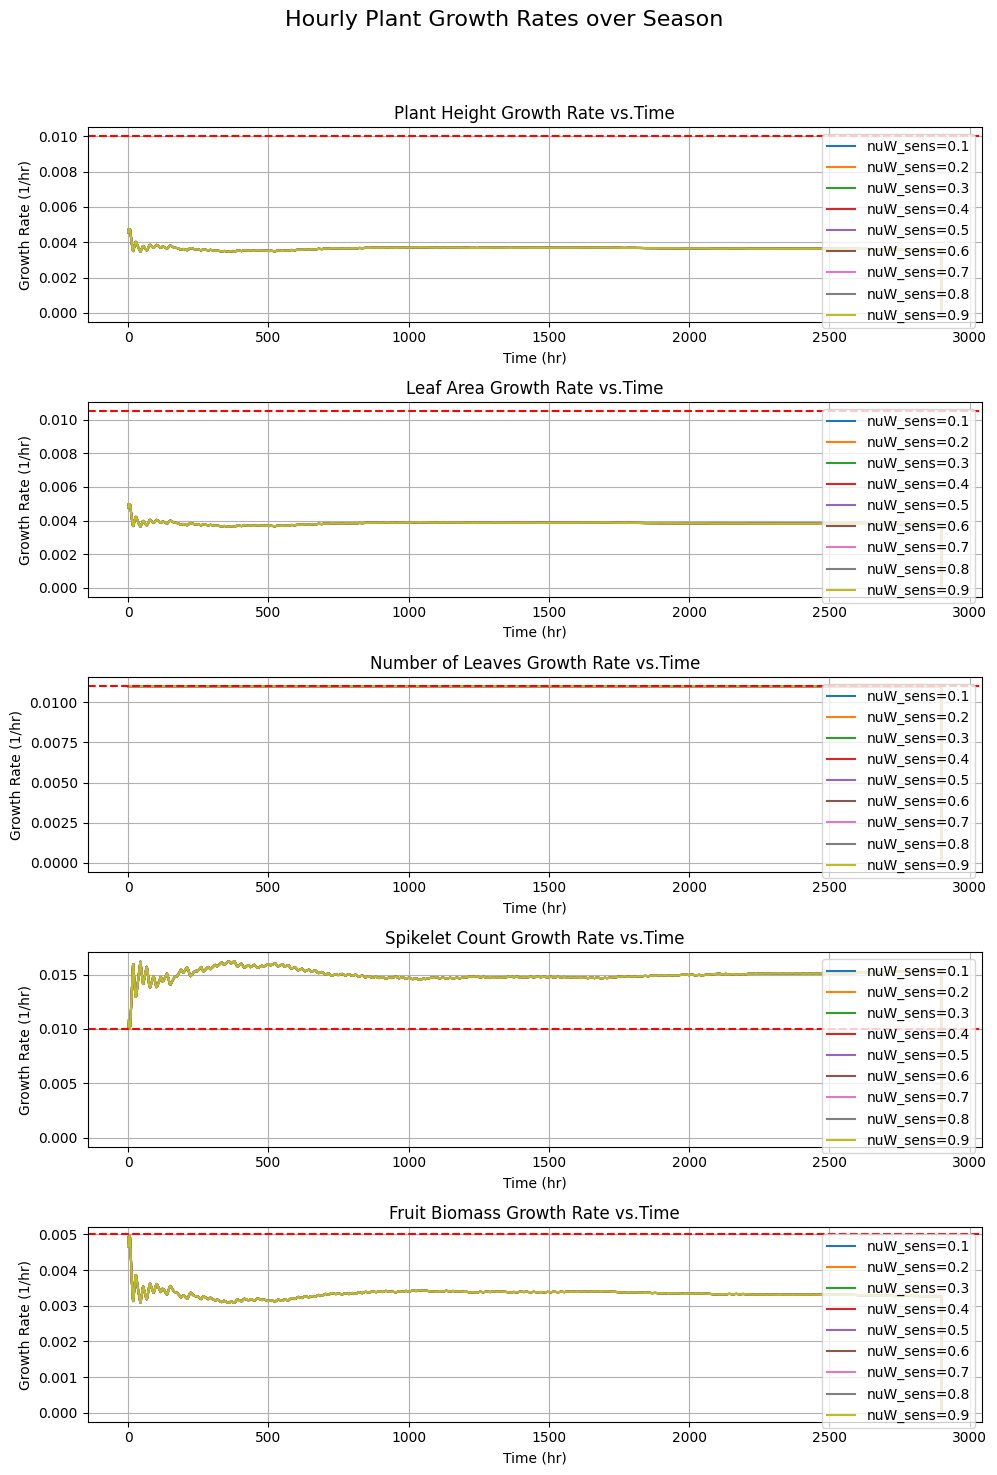

In [20]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass growth rates over time
plot_growth_rate_evolution(
    growth_rates=growth_rates,
    ah_hats=ah_hats,
    aA_hats=aA_hats,
    aN_hats=aN_hats,
    ac_hats=ac_hats,
    aP_hats=aP_hats,
    dt=model_params.dt,
    labels=labels
)

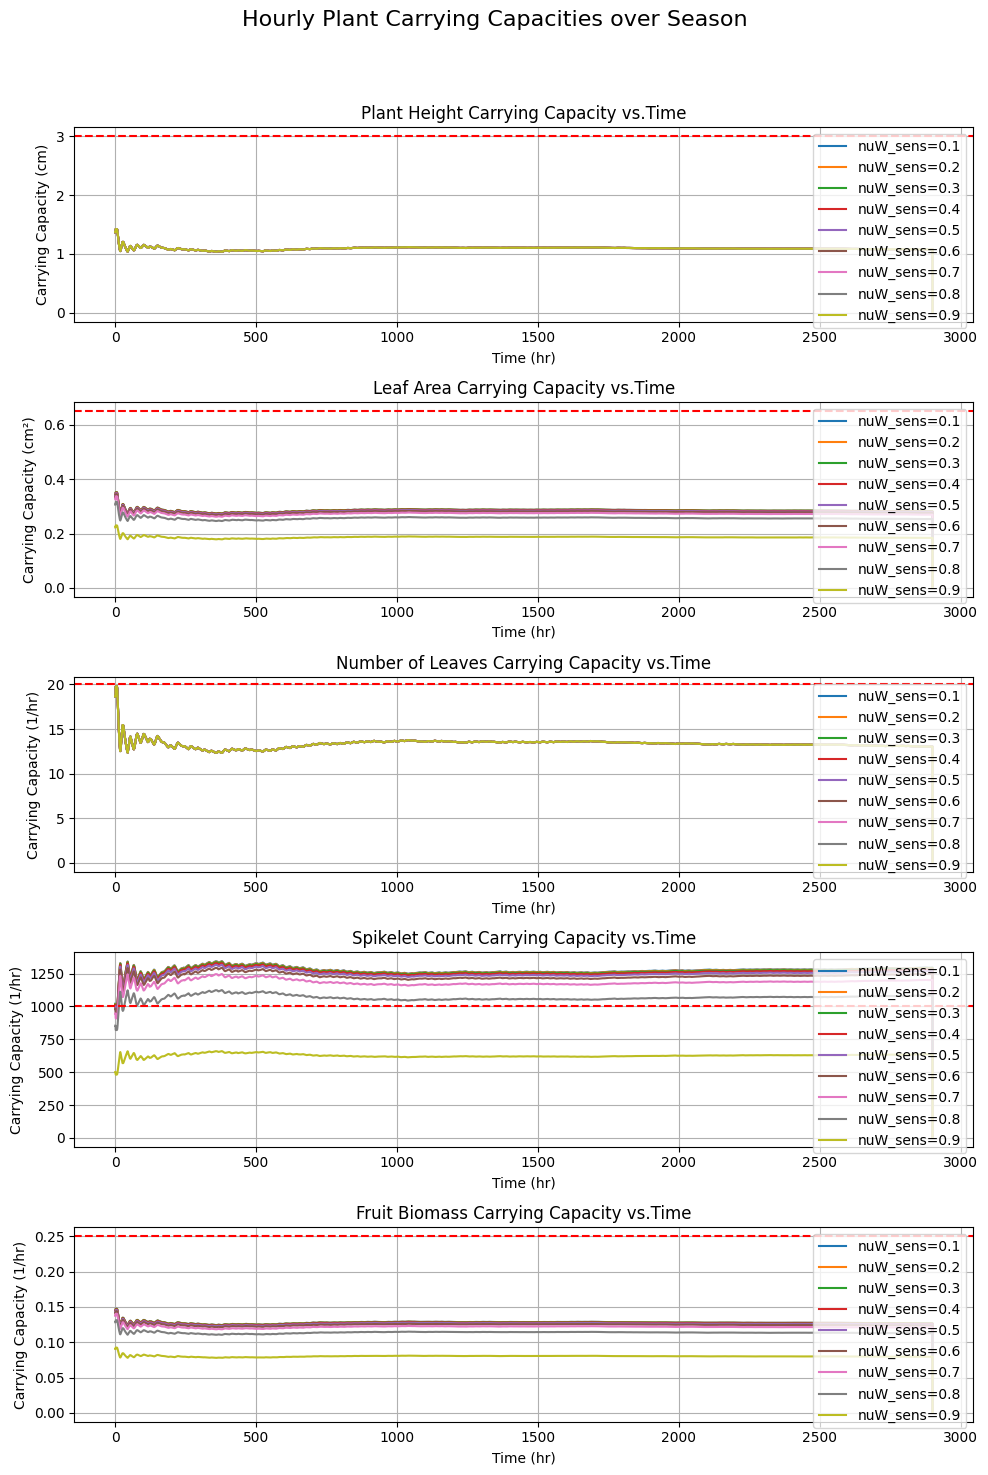

In [21]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass carrying capacities over time
plot_carrying_capacity_evolution(
    carrying_capacities=carrying_capacities,
    kh_hats=kh_hats,
    kA_hats=kA_hats,
    kN_hats=kN_hats,
    kc_hats=kc_hats,
    kP_hats=kP_hats,
    dt=model_params.dt,
    labels=labels
)

## Simulate over different FERTILIZER sensitivities

In [22]:
# Loop over sensitivity values for nuF using default values for others
hs = []
As = []
Ns = []
cs = []
Ps = []
labels = []

nuWs = []
nuFs = []
nuTs = []
nuRs = []

ah_hats = []
aA_hats = []
aN_hats = []
ac_hats = []
aP_hats = []

kh_hats = []
kA_hats = []
kN_hats = []
kc_hats = []
kP_hats = []

for nuF_sens in nuF_sensitivities:
    print(f"Running simulation with nuF sensitivity: {nuF_sens}")
    h, A, N, c, P, nuW_values, nuF_values, nuT_values, nuR_values, ah_hat_values, aA_hat_values, aN_hat_values, ac_hat_values, aP_hat_values, kh_hat_values, kA_hat_values, kN_hat_values, kc_hat_values, kP_hat_values = member.get_closed_form_cost_verbose(nuW_sens=nuW_sens_default, nuF_sens=nuF_sens, nuT_sens=nuT_sens_default, nuR_sens=nuR_sens_default)
    hs.append(h)
    As.append(A)
    Ns.append(N)
    cs.append(c)
    Ps.append(P)
    labels.append(f'nuF_sens={nuF_sens}')

    nuWs.append(nuW_values)
    nuFs.append(nuF_values)
    nuTs.append(nuT_values)
    nuRs.append(nuR_values)

    ah_hats.append(ah_hat_values)
    aA_hats.append(aA_hat_values)
    aN_hats.append(aN_hat_values)
    ac_hats.append(ac_hat_values)
    aP_hats.append(aP_hat_values)

    kh_hats.append(kh_hat_values)
    kA_hats.append(kA_hat_values)
    kN_hats.append(kN_hat_values)
    kc_hats.append(kc_hat_values)
    kP_hats.append(kP_hat_values)

Running simulation with nuF sensitivity: 0.1
Running simulation with nuF sensitivity: 0.2
Running simulation with nuF sensitivity: 0.3
Running simulation with nuF sensitivity: 0.4
Running simulation with nuF sensitivity: 0.5
Running simulation with nuF sensitivity: 0.6
Running simulation with nuF sensitivity: 0.7
Running simulation with nuF sensitivity: 0.8
Running simulation with nuF sensitivity: 0.9


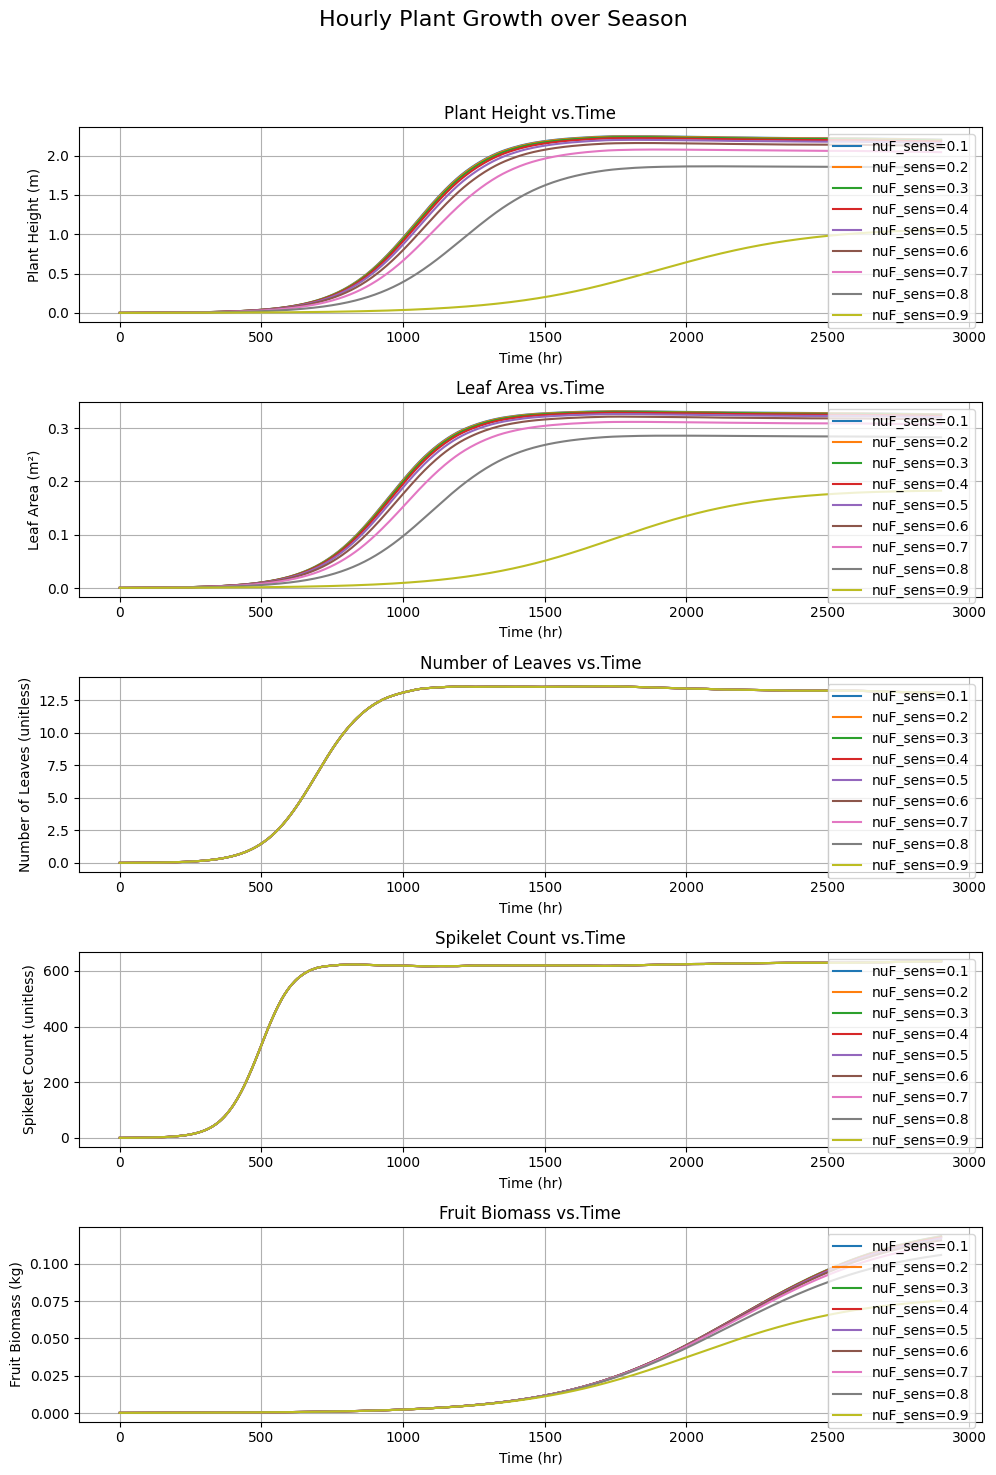

In [23]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass over time
plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    dt=model_params.dt,
    labels=labels
)

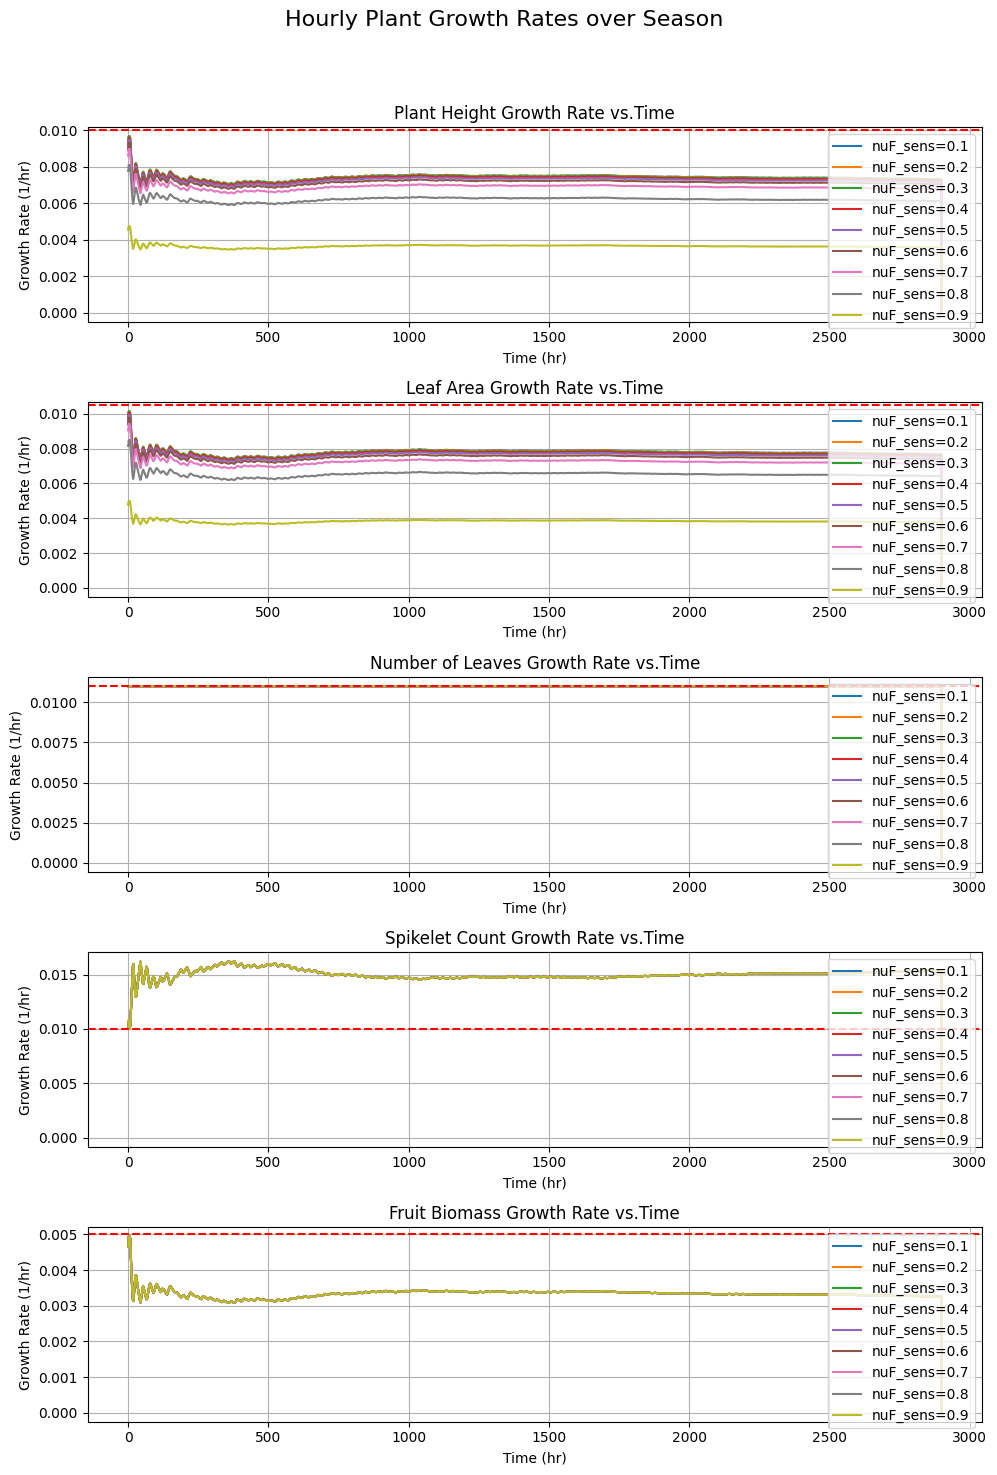

In [24]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass growth rates over time
plot_growth_rate_evolution(
    growth_rates=growth_rates,
    ah_hats=ah_hats,
    aA_hats=aA_hats,
    aN_hats=aN_hats,
    ac_hats=ac_hats,
    aP_hats=aP_hats,
    dt=model_params.dt,
    labels=labels
)

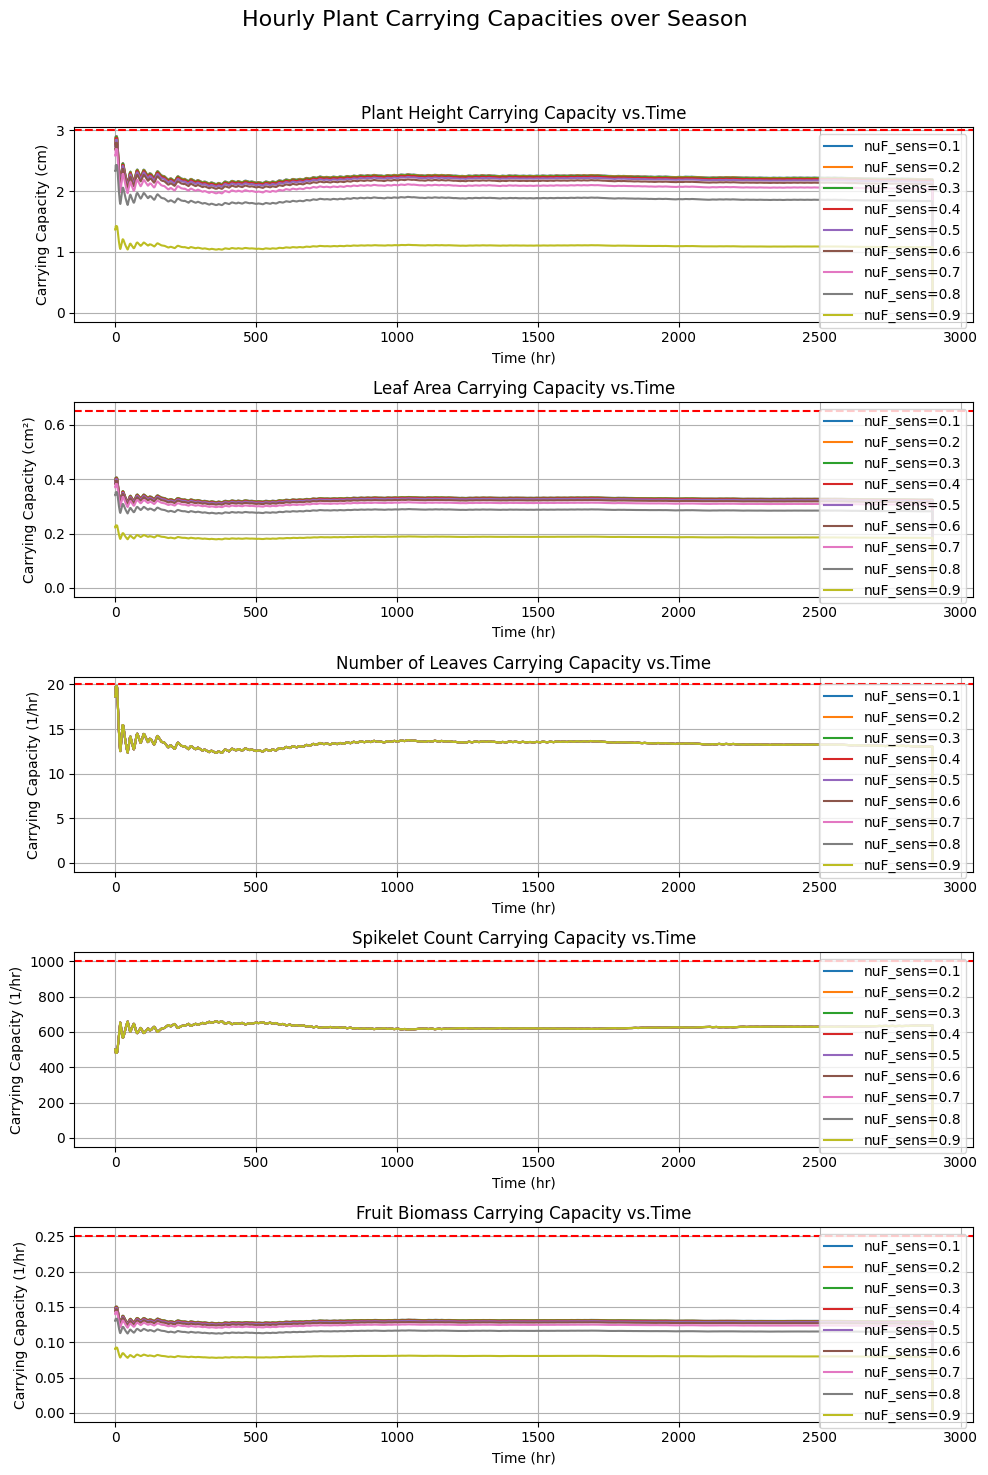

In [25]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass carrying capacities over time
plot_carrying_capacity_evolution(
    carrying_capacities=carrying_capacities,
    kh_hats=kh_hats,
    kA_hats=kA_hats,
    kN_hats=kN_hats,
    kc_hats=kc_hats,
    kP_hats=kP_hats,
    dt=model_params.dt,
    labels=labels
)

## Simulate over different TEMPERATURE sensitivities

In [26]:
# Loop over sensitivity values for nuT using default values for others
hs = []
As = []
Ns = []
cs = []
Ps = []
labels = []

nuWs = []
nuFs = []
nuTs = []
nuRs = []

ah_hats = []
aA_hats = []
aN_hats = []
ac_hats = []
aP_hats = []

kh_hats = []
kA_hats = []
kN_hats = []
kc_hats = []
kP_hats = []

for nuT_sens in nuT_sensitivities:
    print(f"Running simulation with nuT sensitivity: {nuT_sens}")
    h, A, N, c, P, nuW_values, nuF_values, nuT_values, nuR_values, ah_hat_values, aA_hat_values, aN_hat_values, ac_hat_values, aP_hat_values, kh_hat_values, kA_hat_values, kN_hat_values, kc_hat_values, kP_hat_values = member.get_closed_form_cost_verbose(nuW_sens=nuW_sens_default, nuF_sens=nuF_sens_default, nuT_sens=nuT_sens, nuR_sens=nuR_sens_default)
    hs.append(h)
    As.append(A)
    Ns.append(N)
    cs.append(c)
    Ps.append(P)
    labels.append(f'nuT_sens={nuT_sens}')

    nuWs.append(nuW_values)
    nuFs.append(nuF_values)
    nuTs.append(nuT_values)
    nuRs.append(nuR_values)

    ah_hats.append(ah_hat_values)
    aA_hats.append(aA_hat_values)
    aN_hats.append(aN_hat_values)
    ac_hats.append(ac_hat_values)
    aP_hats.append(aP_hat_values)

    kh_hats.append(kh_hat_values)
    kA_hats.append(kA_hat_values)
    kN_hats.append(kN_hat_values)
    kc_hats.append(kc_hat_values)
    kP_hats.append(kP_hat_values)

Running simulation with nuT sensitivity: 0.1
Running simulation with nuT sensitivity: 0.2
Running simulation with nuT sensitivity: 0.3
Running simulation with nuT sensitivity: 0.4
Running simulation with nuT sensitivity: 0.5
Running simulation with nuT sensitivity: 0.6
Running simulation with nuT sensitivity: 0.7
Running simulation with nuT sensitivity: 0.8
Running simulation with nuT sensitivity: 0.9


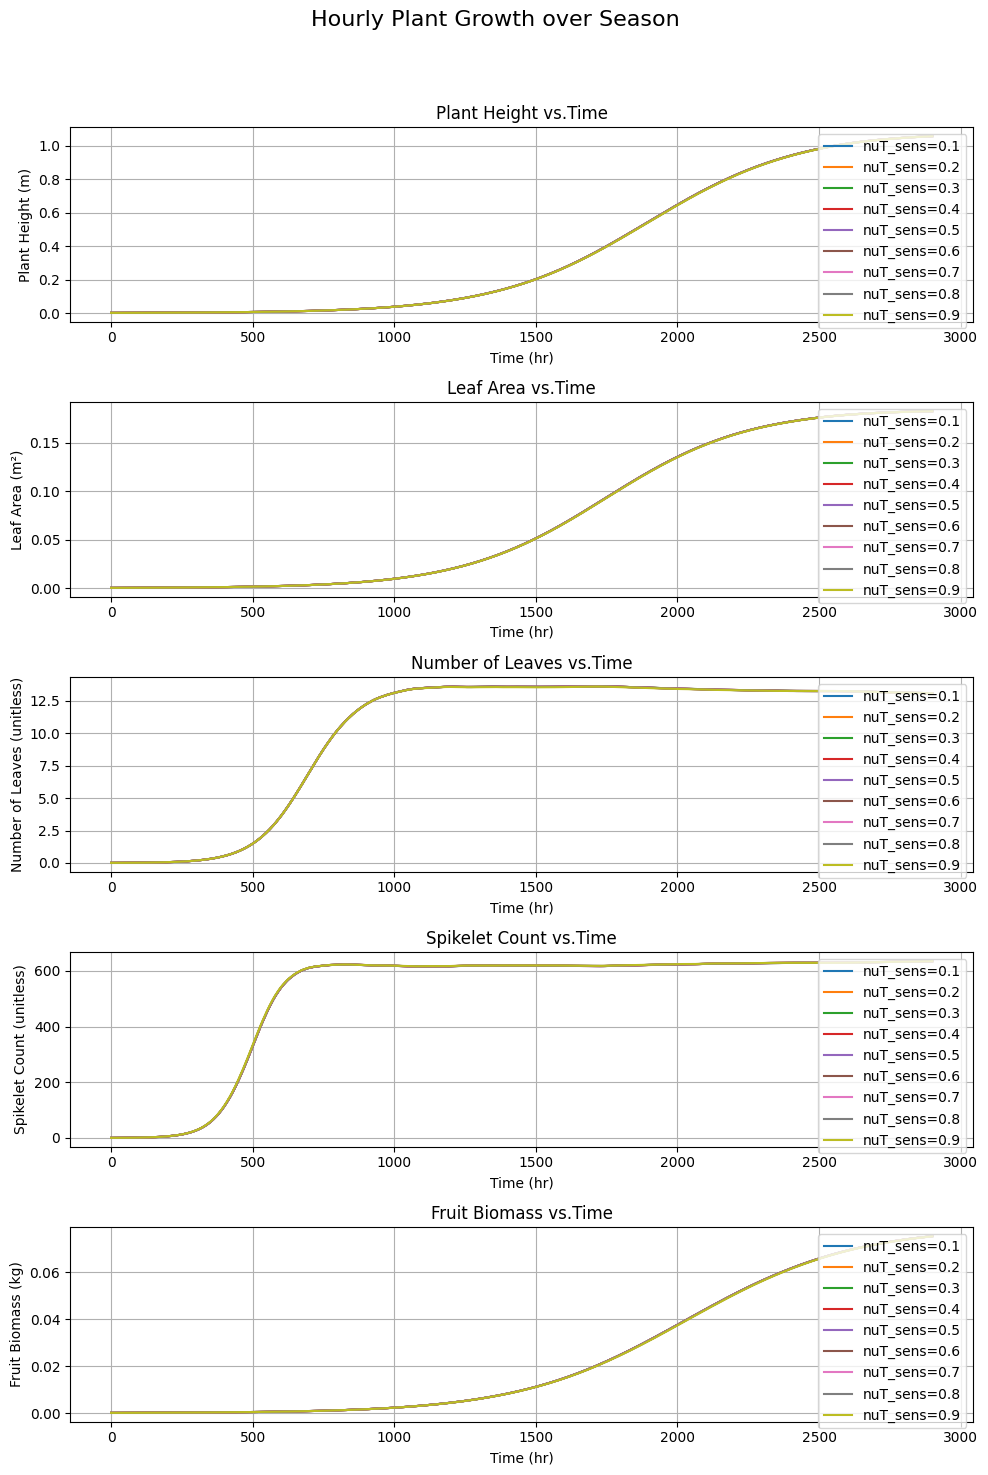

In [27]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass over time
plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    dt=model_params.dt,
    labels=labels
)

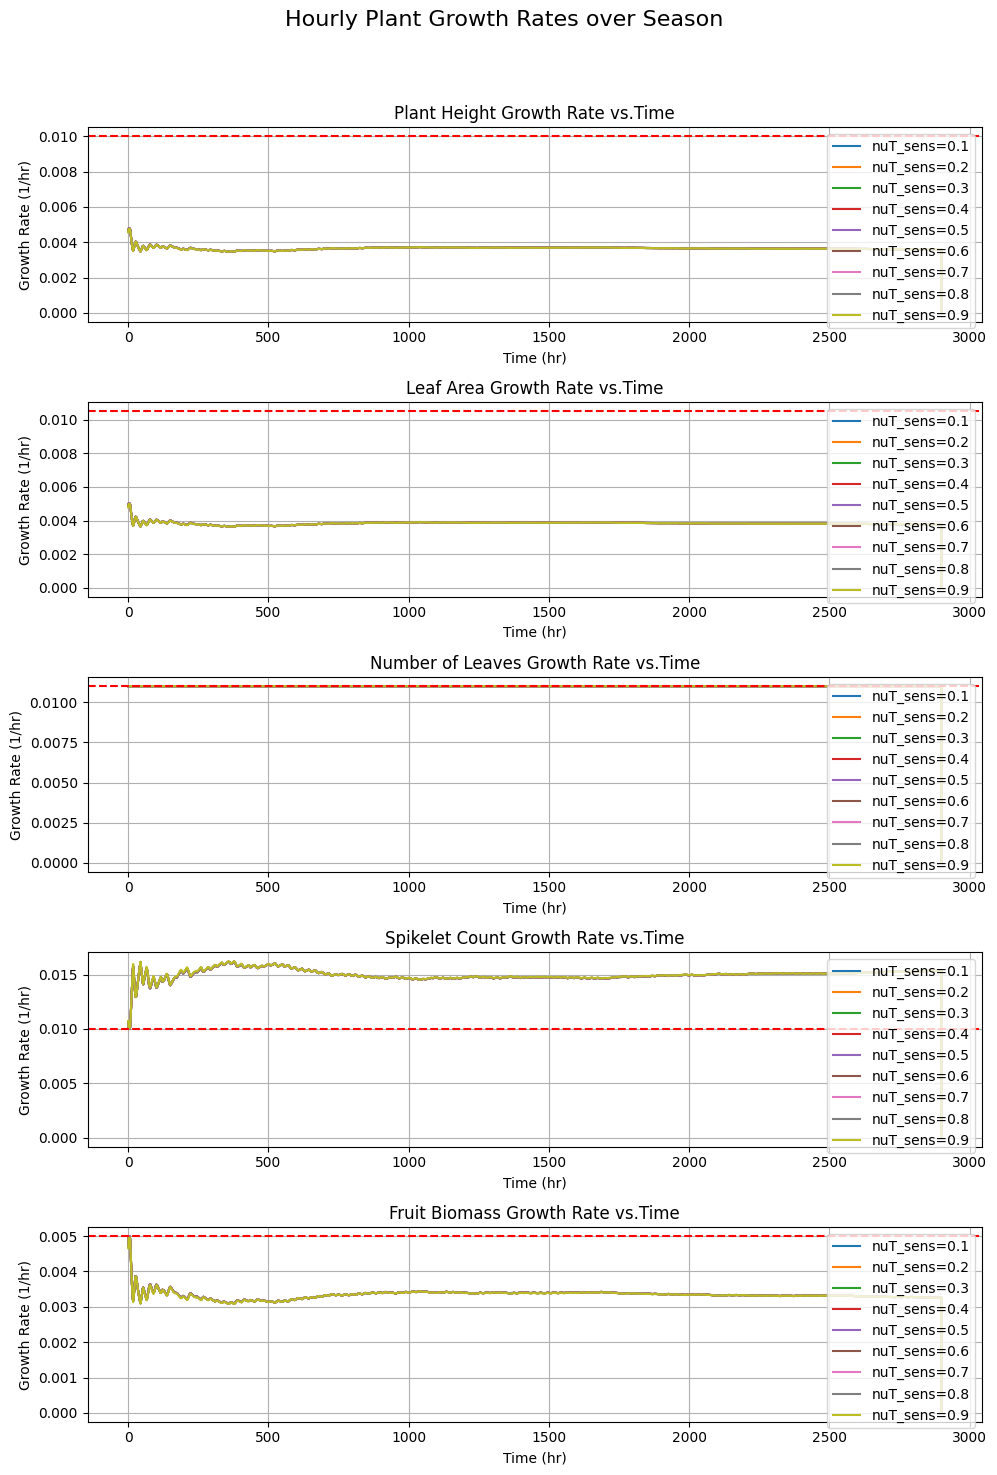

In [28]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass growth rates over time
plot_growth_rate_evolution(
    growth_rates=growth_rates,
    ah_hats=ah_hats,
    aA_hats=aA_hats,
    aN_hats=aN_hats,
    ac_hats=ac_hats,
    aP_hats=aP_hats,
    dt=model_params.dt,
    labels=labels
)

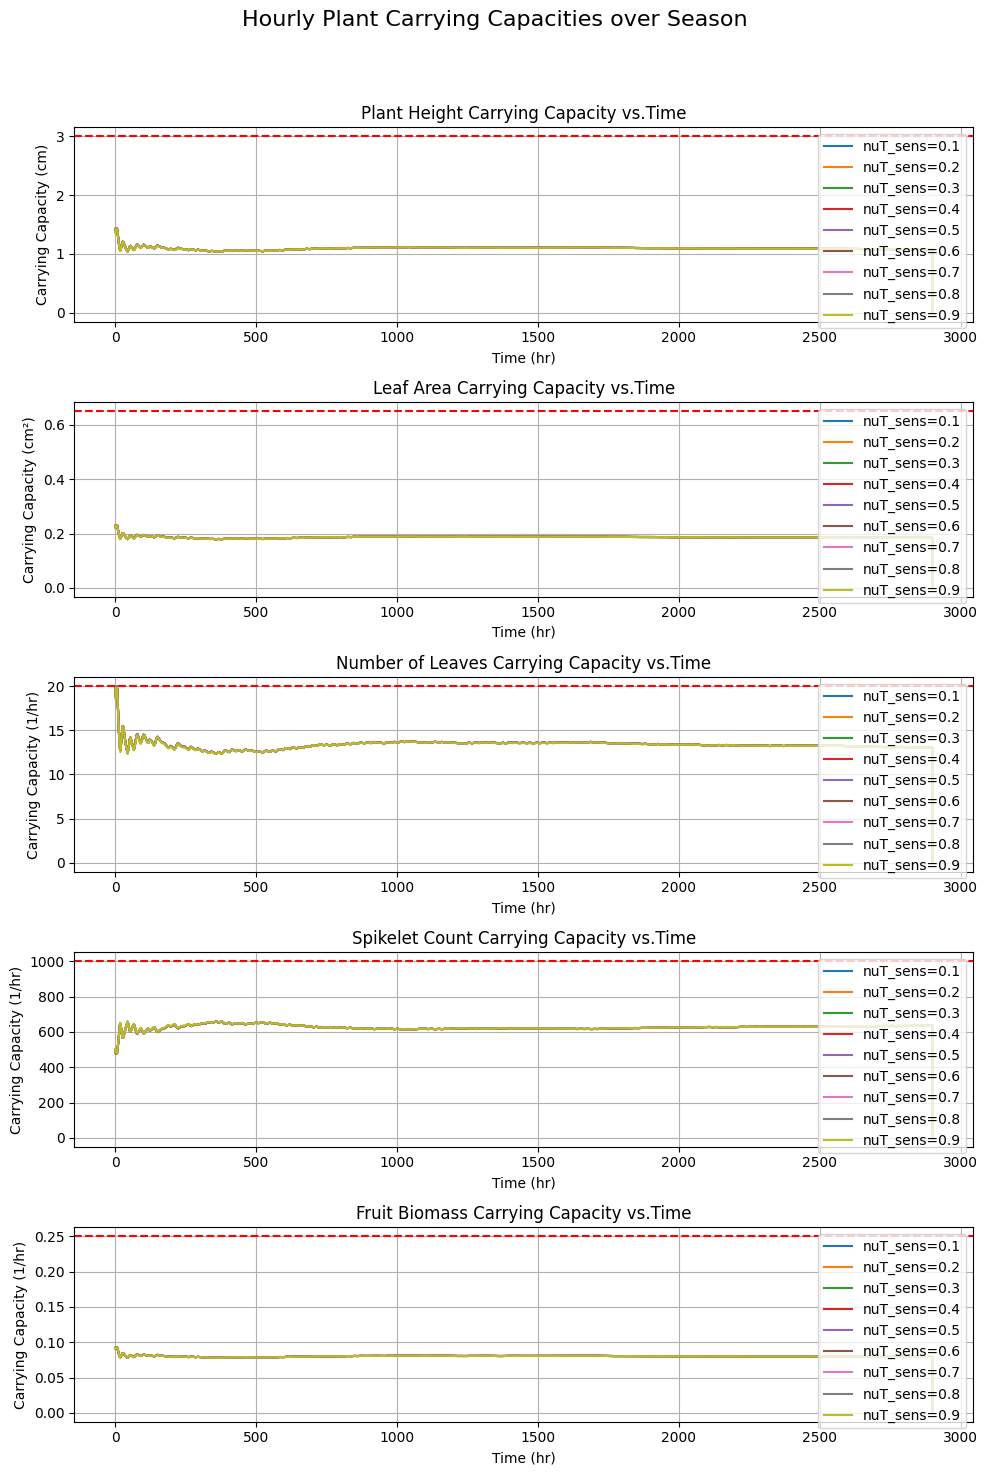

In [29]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass carrying capacities over time
plot_carrying_capacity_evolution(
    carrying_capacities=carrying_capacities,
    kh_hats=kh_hats,
    kA_hats=kA_hats,
    kN_hats=kN_hats,
    kc_hats=kc_hats,
    kP_hats=kP_hats,
    dt=model_params.dt,
    labels=labels
)

## Simulate over different RADIATION sensitivities

In [30]:
# Loop over sensitivity values for nuR using default values for others
hs = []
As = []
Ns = []
cs = []
Ps = []
labels = []

nuWs = []
nuFs = []
nuTs = []
nuRs = []

ah_hats = []
aA_hats = []
aN_hats = []
ac_hats = []
aP_hats = []

kh_hats = []
kA_hats = []
kN_hats = []
kc_hats = []
kP_hats = []

for nuR_sens in nuR_sensitivities:
    print(f"Running simulation with nuR sensitivity: {nuR_sens}")
    h, A, N, c, P, nuW_values, nuF_values, nuT_values, nuR_values, ah_hat_values, aA_hat_values, aN_hat_values, ac_hat_values, aP_hat_values, kh_hat_values, kA_hat_values, kN_hat_values, kc_hat_values, kP_hat_values = member.get_closed_form_cost_verbose(nuW_sens=nuW_sens_default, nuF_sens=nuF_sens_default, nuT_sens=nuT_sens_default, nuR_sens=nuR_sens)
    hs.append(h)
    As.append(A)
    Ns.append(N)
    cs.append(c)
    Ps.append(P)
    labels.append(f'nuR_sens={nuR_sens}')

    nuWs.append(nuW_values)
    nuFs.append(nuF_values)
    nuTs.append(nuT_values)
    nuRs.append(nuR_values)

    ah_hats.append(ah_hat_values)
    aA_hats.append(aA_hat_values)
    aN_hats.append(aN_hat_values)
    ac_hats.append(ac_hat_values)
    aP_hats.append(aP_hat_values)

    kh_hats.append(kh_hat_values)
    kA_hats.append(kA_hat_values)
    kN_hats.append(kN_hat_values)
    kc_hats.append(kc_hat_values)
    kP_hats.append(kP_hat_values)

Running simulation with nuR sensitivity: 0.1
Running simulation with nuR sensitivity: 0.2
Running simulation with nuR sensitivity: 0.3
Running simulation with nuR sensitivity: 0.4
Running simulation with nuR sensitivity: 0.5
Running simulation with nuR sensitivity: 0.6
Running simulation with nuR sensitivity: 0.7
Running simulation with nuR sensitivity: 0.8
Running simulation with nuR sensitivity: 0.9


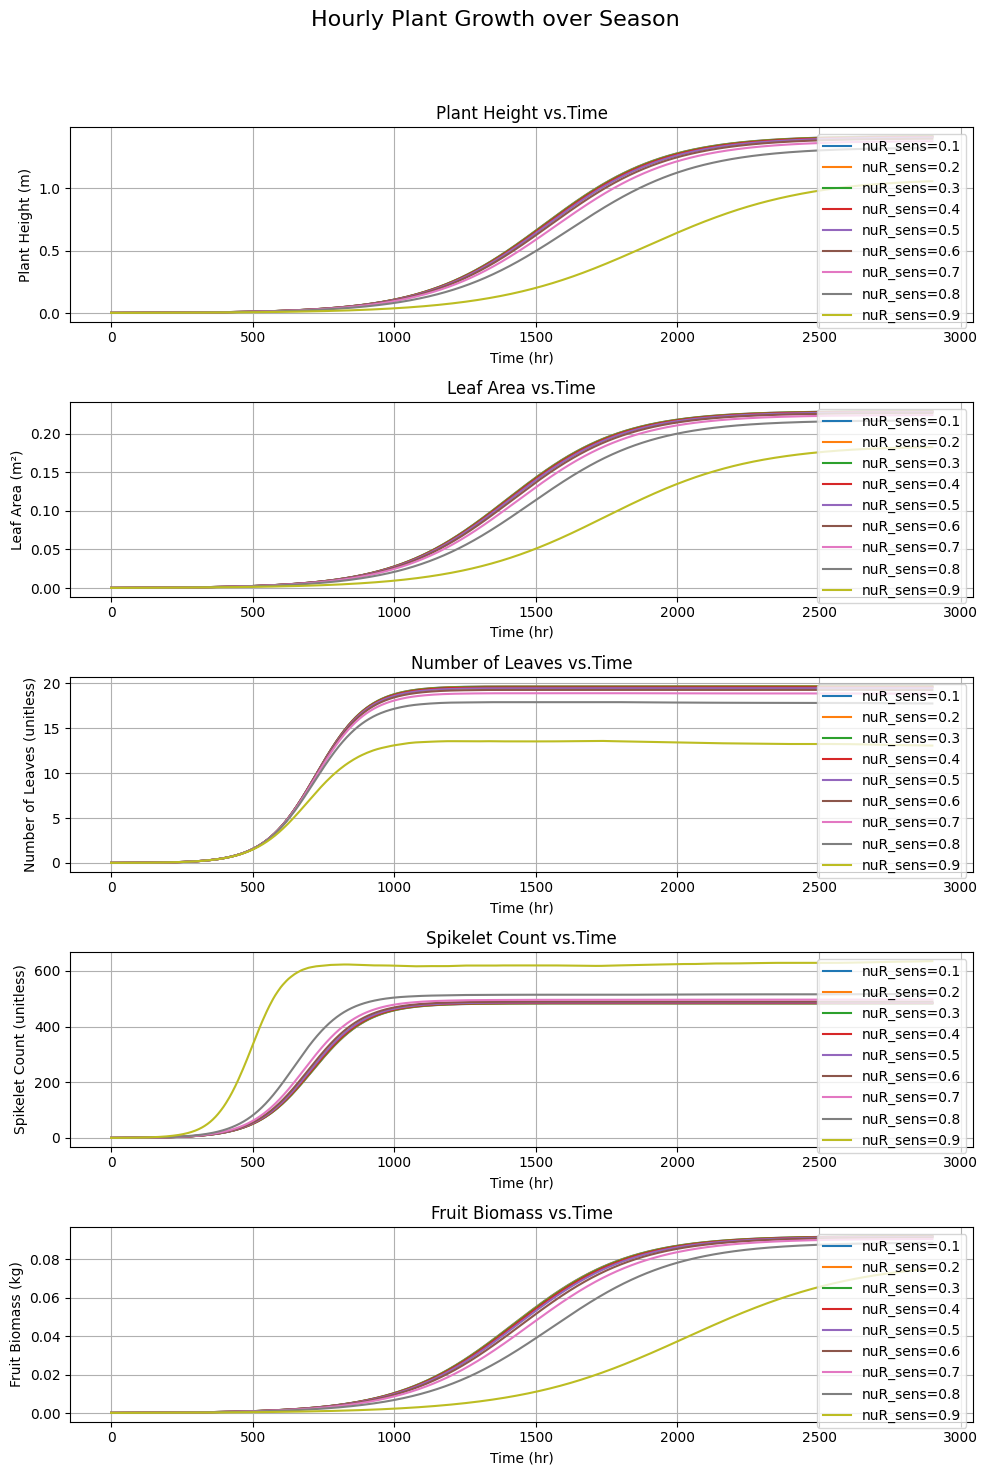

In [31]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass over time
plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    dt=model_params.dt,
    labels=labels
)

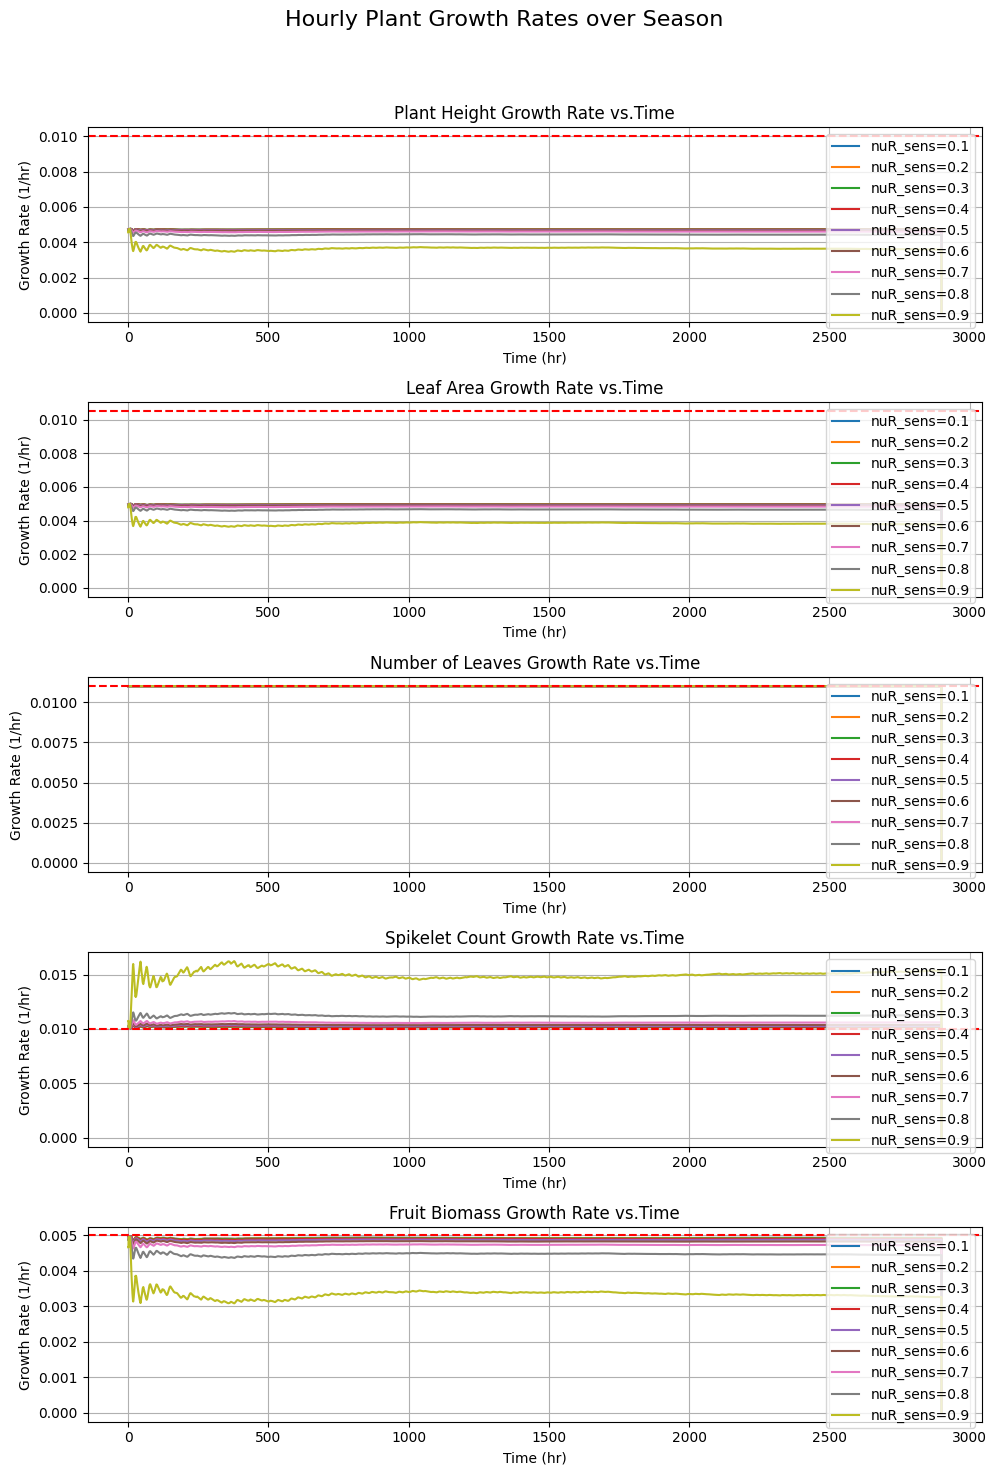

In [32]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass growth rates over time
plot_growth_rate_evolution(
    growth_rates=growth_rates,
    ah_hats=ah_hats,
    aA_hats=aA_hats,
    aN_hats=aN_hats,
    ac_hats=ac_hats,
    aP_hats=aP_hats,
    dt=model_params.dt,
    labels=labels
)

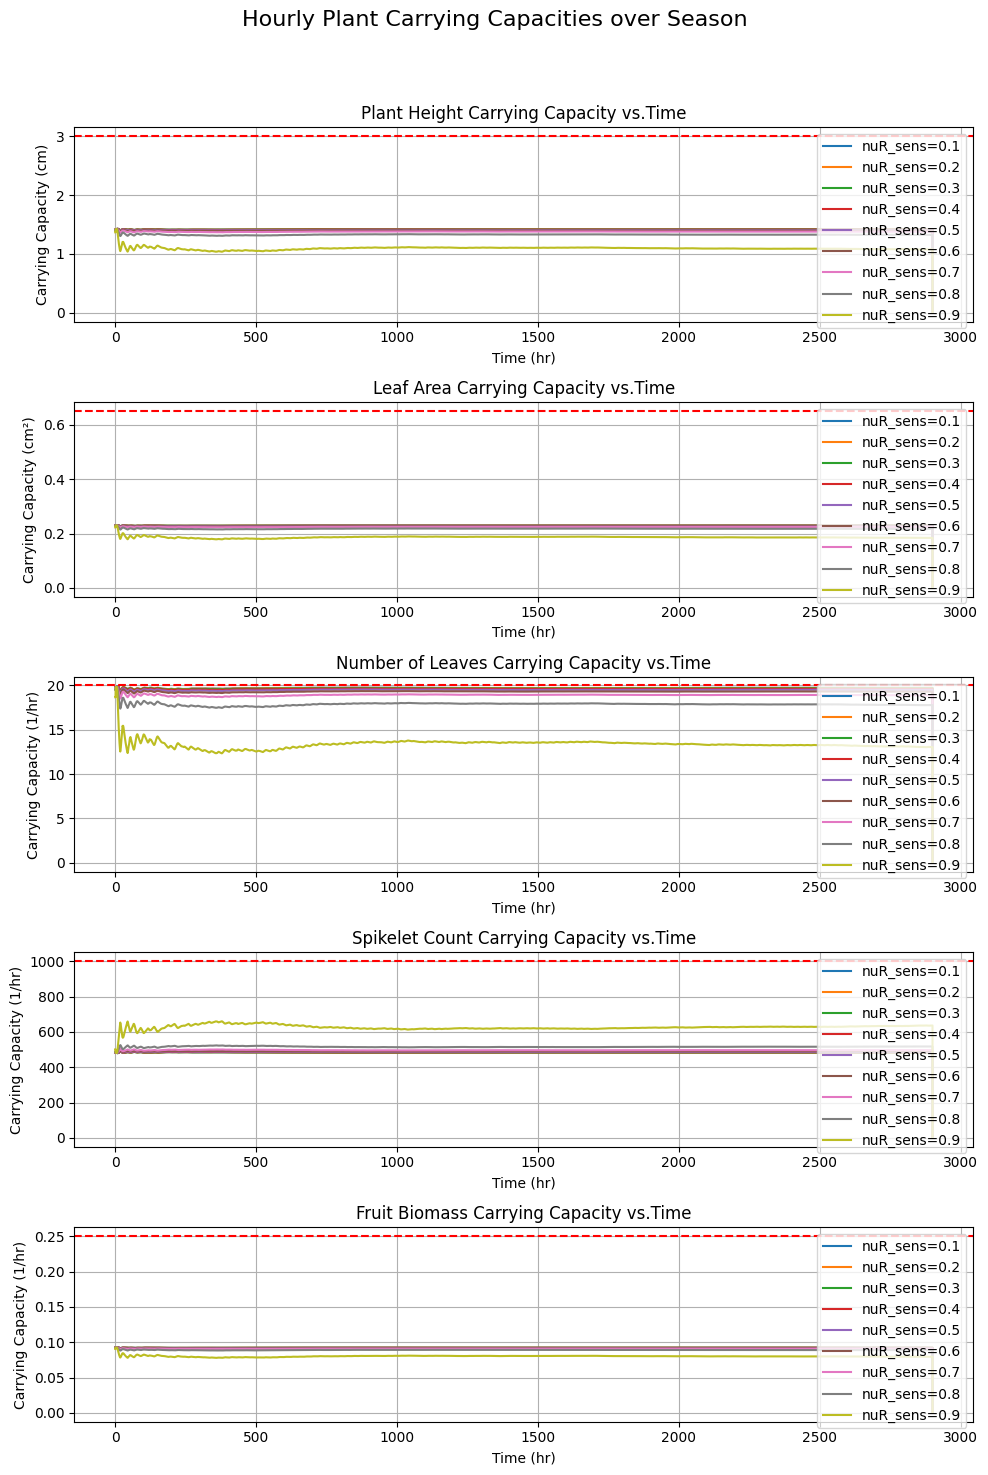

In [33]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass carrying capacities over time
plot_carrying_capacity_evolution(
    carrying_capacities=carrying_capacities,
    kh_hats=kh_hats,
    kA_hats=kA_hats,
    kN_hats=kN_hats,
    kc_hats=kc_hats,
    kP_hats=kP_hats,
    dt=model_params.dt,
    labels=labels
)